In [1]:
# @title Loading data
from google.colab import drive
drive.mount('/content/drive')


file_path = '/content/drive/My Drive/Colab_Notebooks/lorentz_long_x.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

Mounted at /content/drive


In [2]:
# @title Loading optuna
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


Data length: 1048575


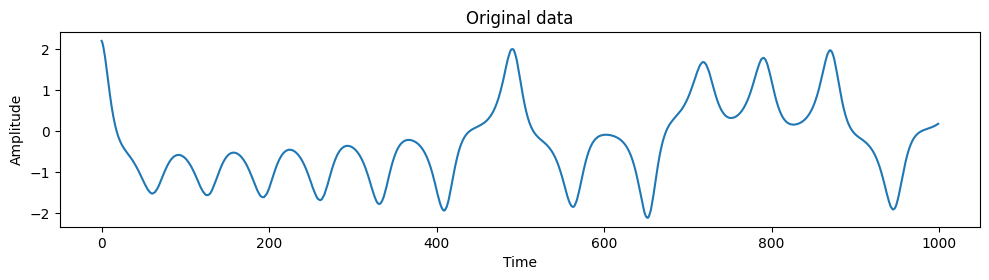

In [3]:
# @title Data reshaping

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv


# find missing values
nan_indices = np.where(np.isnan(data))

# delete missing values
data = np.delete(data, nan_indices)

# average and standard deviation
mean_value = np.mean(data)
std_dev = np.std(data)

# Standardization
data = (data - mean_value) / std_dev


print('Data length:',data.size)

#######
# Visualization

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data[:1000])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()


Weight function of RealtimeFilter

$$\Psi(t)=
 \underbrace{\left(d_1\cos\left(\frac{t}{\pi r_1}\right)+d_2\cos\left(\frac{ t}{\pi r_2}\right)\right)}_{passing\ freq}
 \underbrace{\frac{(width+t)^c}{width^c}}_{band\ width}$$

In [4]:
# @title Definitions of RealtimeFilter and ``dictionary" for pattern extraction

from scipy import signal

################
#Sigmoid function

def sigmoid(x,a,b):
    return 1 / (1 + np.exp(-a*(x-b)))

################
#RealtimeFilter code
################

class rb_filter:
    def __init__(self, r_1, r_2, c,d_1,d_2, width, height, delta_t=1):

        self.width = width
        self.t_w = np.arange(-self.width, 0, delta_t)
        self.weight =  (d_1*np.cos(self.t_w/(np.pi*r_1))+d_2*np.cos(self.t_w/(np.pi*r_2)))* ((width+self.t_w)**c)/(width**c)
        self.delta_t = delta_t
        self.weight = self.weight / height



    def calc(self, data,T_train):
        data_flt = np.zeros(T_train)
        data_flt[:] = np.nan
        for i in range(self.width, T_train):
            data_flt[i] = np.sum(data[i-self.width+1:i+1]*self.weight)
        return data_flt

    def timeweight(self):
        return self.t_w, self.weight


def auto_correlation(data1_in, data2_in, width,lg):
    n = len(data1_in)
    mean1 = np.mean(data1_in[width:n-width])
    mean2 = np.mean(data2_in[width:n-width])
    numerator = np.sum((data1_in[width:n - width- lg] - mean1) * (data2_in[width + lg:n-width] - mean2))
    denominator = np.sqrt(np.sum((data1_in[width:n-width-lg] - mean1) ** 2)) * np.sqrt(np.sum((data2_in[width +lg: n-width] - mean2) ** 2))
    return numerator / denominator

########################################
###Dictionary for pattern extraction
########################################

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import datetime
import networkx as nx
import csv
import math
from collections import Counter, defaultdict

#Extract patterns and next values

def extract_patterns_and_next_values(discretized_data, max_dim,min_count, min_dim):

    patterns = []
    next_values = defaultdict(list)
    pattern_counts = Counter()


#Collect pair of pattern and next value

    for dim in range(max_dim, min_dim, -1):
        num_patterns = len(discretized_data) - dim

        for i in range(num_patterns):
            pattern = tuple(discretized_data[i:i+dim])  #Pattern
            next_value = discretized_data[i+dim]        #next value
            patterns.append(pattern)
            next_values[pattern].append(next_value)
            pattern_counts[pattern] += 1


# Delete fewer occurrences
    patterns = [pattern for pattern in patterns if pattern_counts[pattern] >= min_count]
    next_values = {pattern: values for pattern, values in next_values.items() if pattern_counts[pattern] >= min_count}

# Collect occurances of each patterns into frequency_array
    filtered_pattern_counts = {pattern: count for pattern, count in pattern_counts.items() if count >= min_count}
    frequency_array = np.array(list(filtered_pattern_counts.values()))



#In ``next_values", there already exist pairs of pattern and next value

    assigned_values, assigned_value_counts = assign_most_frequent_next_value_to_patterns(next_values)


    # calculate majority_ratio
    majority_ratio = {}
    for pattern in assigned_values:
        if pattern in pattern_counts:
            majority_ratio[pattern] = float(assigned_value_counts[pattern]) / float(pattern_counts[pattern])


    return patterns, next_values, frequency_array, filtered_pattern_counts, majority_ratio


#########
##Assign the most frequent next value to each patterns

def assign_most_frequent_next_value_to_patterns(next_values):
    assigned_values = {}
    assigned_value_counts = {}
    for dim in range(max_dim, 0, -1):

        for pattern, values in next_values.items():
            counts = Counter(values)
            most_common_value = counts.most_common(1)[0][0]
            assigned_values[pattern] = most_common_value
            assigned_value_counts[pattern] = counts[most_common_value]
    return assigned_values, assigned_value_counts


##Fitting original data to disretized range

def discretize_time_series(data, inverse_cdf_values):
    discretized_data = []
    for value in data:

        nearest_value = min(inverse_cdf_values, key=lambda x: abs(x - value))
        discretized_data.append(nearest_value)

    return discretized_data

In [5]:
# @title Hyperparameter: Training length (automatically the starting test time T_0 is determined)

T_train = 500

In [6]:
# @title Hyperparameter: Bayesian optimization for RealtimeFilter

n_trials   = 50         #number of trials for optuna
max_dim    = 40         #Max pattern length
min_dim    = 5          #Min pattern length
min_count  = 5          #delete patterns if occurrence is fewer than this
n_bins     = 10         #number of partitions of range
min_majority_ratio =0.9 #minimum requirement for majority_ratio

In [7]:
# @title Implementation of Bayesian optimization of RealtimeFilter

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))


#Initial filter height is 1

height=1

#####################################
#We can load (in csv file) and reuse the past trials


file_path = 'filter.csv'
past_trials = []

if os.path.exists(file_path):

   with open(file_path, mode='r', newline='') as file:
       reader = csv.DictReader(file)
       for row in reader:

        # Data processing and incorporation into past_trials
           trial_data = {
               'value': float(row['value']),
               'params': {
                   'r_1': float(row['r_1']),
                   'r_2': float(row['r_2']),
                   'c': float(row['c']),
                   'd_1': float(row['d_1']),
                   'd_2': float(row['d_2']),
                   'width': int(row['width'])
               }
           }
           past_trials.append(trial_data)



# Creating an Optuna Study
study = optuna.create_study(direction="maximize")


###############


# Add past attempts to study
for trial in past_trials:

    if 'value' not in trial:
        print(f"Skipping trial as it does not contain 'value': {trial}")
        continue

    try:
          value = float(trial['value'])  # Guarantee that value is a float type
    except ValueError as e:
          print(f"Error converting trial value to float: {e}")
          continue  # Proceed to the next TRIAL


    frozen_trial = FrozenTrial(
        number=study._storage.get_n_trials(study._study_id),
        state=TrialState.COMPLETE,
        value=trial['value'],
        datetime_start=datetime.now(),
        datetime_complete=datetime.now(),
        params=trial['params'],
        distributions={
            'r_1': optuna.distributions.FloatDistribution(2.5, 8),#Especially on the high-frequency side, adjust while checking the SMOOTHING!
            'r_2': optuna.distributions.FloatDistribution(2.5, 8),#Especially on the high-frequency side, adjust while checking the SMOOTHING!
            'c': optuna.distributions.FloatDistribution(0.2, 1),
            'd_1': optuna.distributions.FloatDistribution(0, 10),
            'd_2': optuna.distributions.FloatDistribution(0, 10),
            'width': optuna.distributions.IntUniformDistribution(20, 150),
        },
        user_attrs={},
        system_attrs={},
        intermediate_values={},
        trial_id=study._storage.create_new_trial(study._study_id)
    )
    study.add_trial(frozen_trial)

# Objective Function Definition
def objective(trial):
    r_1 = trial.suggest_float("r_1", 2.5, 8)#Especially on the high-frequency side, adjust while checking the SMOOTHING!
    r_2 = trial.suggest_float("r_2", 2.5, 8)#Especially on the high-frequency side, adjust while checking the SMOOTHING!
    c = trial.suggest_float("c", 0.2, 1)
    d_1 = trial.suggest_float("d_1", 0, 10)
    d_2 = trial.suggest_float("d_2", 0, 10)
    width = trial.suggest_int("width", 20, 150)



############
# Apply Filter
    delta_t = 1
    filter = rb_filter(r_1, r_2, c, d_1, d_2,width, delta_t)
    data_flt = filter.calc(data,T_train)
    data_flt = np.nan_to_num(data_flt, nan=0.0)



#####################
#Discretize value range using cumulative distribution function (CDF)
#####################


# Calculate cumulative distribution function (CDF)
    cdf_values, bin_edges = np.histogram(data_flt[0:T_train], bins='auto', density=True)
    cdf_values = np.cumsum(cdf_values)

# Generates equally spaced probability values
    probability_values = np.linspace(0, 1, n_bins + 1)

# Compute inverse CDF to obtain n_bins values
    inverse_cdf_values = np.interp(probability_values, cdf_values / cdf_values[-1], bin_edges[:-1])


    discretized_data= None
    pattens =None
    next_values = None
    assigned_values = None


# Fitting data to discrete values
    discretized_data = np.array(discretize_time_series(data_flt[0:T_train], inverse_cdf_values))

    patterns, next_values, frequency_array, filtered_pattern_counts, majority_ratio = \
    extract_patterns_and_next_values(discretized_data, max_dim,min_count, min_dim)

#################

# Count patterns with majority_ratio greater than or equal to ``min_majority_ratio"
    count_majority = sum(1 for ratio in majority_ratio.values() if ratio >= min_majority_ratio)

# Total number of pattern
    total_patterns = len(majority_ratio)

# Percentage of patterns with majority_ratio greater than or equal to ``min_majority_ratio"
    percentage_majority = count_majority / total_patterns


################
#Require a minimum autocorrelation coefficient
################

    max_lag = 40
    ac_data_flt = []

# calculate autocorrelation coefficient

    for i in range(max_lag + 1):
        ac_flt = auto_correlation(data[:T_train],data_flt[:], width, i)
        ac_data_flt.append(ac_flt)


######################
#OBJECTIVE FUNCTION!!!
######################
#we use the Sigmoid function to predetermine the minimum autocorrelation coefficient we want

    max_value = (percentage_majority ** 1) *sigmoid(np.max(ac_data_flt),20,0.78)


    return max_value


######################

# Implementation
study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

r_1  = trial.params["r_1"]
r_2  = trial.params["r_2"]
c  = trial.params["c"]
d_1 = trial.params["d_1"]
d_2 = trial.params["d_2"]
width = trial.params["width"]

#####################
# save results to CSV
#####################

current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'filter.csv')


# Write additional CSV files with the latest trial data
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

# Writing header lines (first time only)
    if file.tell() == 0:
        writer.writerow(['value', 'r_1', 'r_2', 'c', 'd_1', 'd_2', 'width'])

    # Write all trials
    for trial in study.trials:
        r_1_value = trial.params.get('r_1')
        if r_1_value is not None:  #Write only if r_1 is not None
           writer.writerow([
    trial.value,
    trial.params.get('r_1', None),
    trial.params.get('r_2', None),
    trial.params.get('c', None),
    trial.params.get('d_1', None),
    trial.params.get('d_2', None),
    trial.params.get('width', None),
])

[I 2024-11-16 00:59:29,588] A new study created in memory with name: no-name-3796174e-ef87-48fb-8823-5901876edf89


1048575


[I 2024-11-16 00:59:29,964] Trial 0 finished with value: 0.48756278769737454 and parameters: {'r_1': 7.874874537423772, 'r_2': 7.2480877266366335, 'c': 0.41985233264339217, 'd_1': 1.9448380295259182, 'd_2': 3.235519243932836, 'width': 48}. Best is trial 0 with value: 0.48756278769737454.
[I 2024-11-16 00:59:30,501] Trial 1 finished with value: 0.44885494557213285 and parameters: {'r_1': 7.266207395425987, 'r_2': 6.092792018488408, 'c': 0.48473373052195917, 'd_1': 6.712390154928079, 'd_2': 9.04304585299985, 'width': 45}. Best is trial 0 with value: 0.48756278769737454.
[I 2024-11-16 00:59:30,840] Trial 2 finished with value: 0.5637868458670422 and parameters: {'r_1': 5.704991019487515, 'r_2': 2.9463217648281597, 'c': 0.8249523564587353, 'd_1': 2.8454069821142793, 'd_2': 8.751245570988337, 'width': 90}. Best is trial 2 with value: 0.5637868458670422.
[I 2024-11-16 00:59:31,194] Trial 3 finished with value: 0.6568316275523498 and parameters: {'r_1': 7.265999894403122, 'r_2': 6.77592434304

Best trial:
  'params': {'r_1': 5.36727009644785, 'r_2': 3.6921082138338397, 'c': 0.8811269971985024, 'd_1': 6.0478242965818865, 'd_2': 2.6552483015465596, 'width': 150},
  'value': 0.7695429701356774,
CPU times: user 19.7 s, sys: 326 ms, total: 20.1 s
Wall time: 41.5 s


In [8]:
# @title Decisive filtering

best_params = study.best_params  # Get the best parameters

r_1          = best_params["r_1"]
r_2          = best_params["r_2"]
c            = best_params["c"]
d_1          = best_params["d_1"]
d_2          = best_params["d_2"]
width        = best_params["width"]


# Output and check
print(f"r_1: {r_1}")
print(f"r_2: {r_2}")
print(f"c: {c}")
print(f"d_1: {d_1}")
print(f"d_2: {d_2}")
print(f"width: {width}")

r_1: 5.36727009644785
r_2: 3.6921082138338397
c: 0.8811269971985024
d_1: 6.0478242965818865
d_2: 2.6552483015465596
width: 150


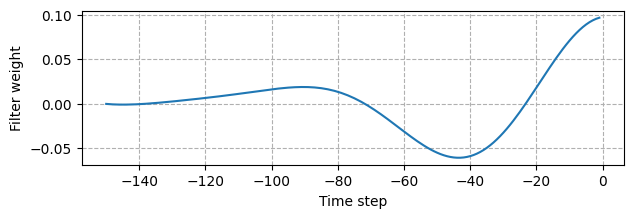

value of objective funct: 0.7695429701356774
autocorrelation: 0.9877693271985678
pattern matching ratio: 0.7816091954022989
Number of Patterns: 87


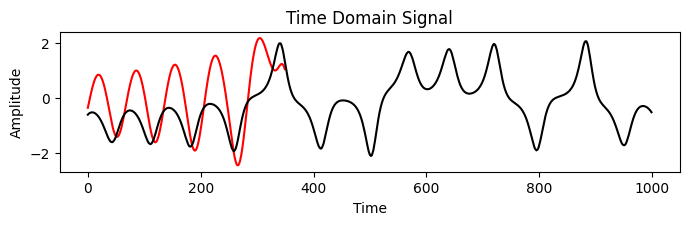

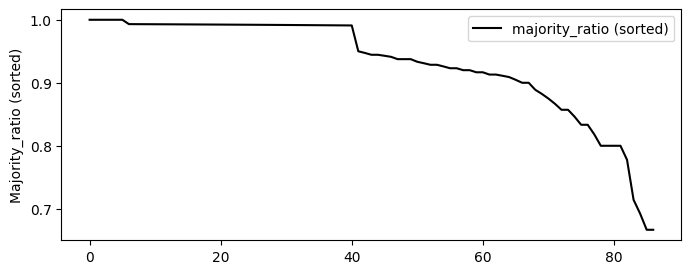

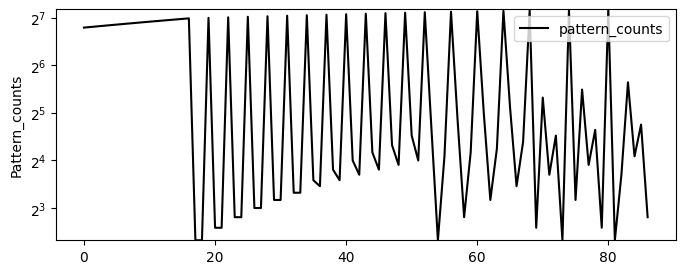

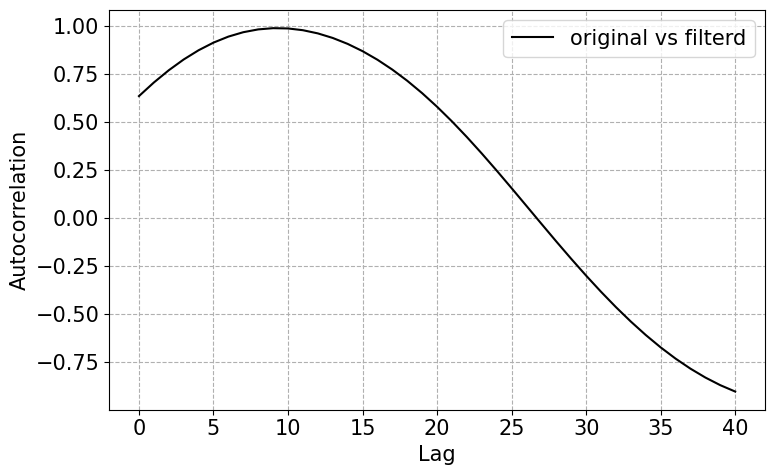

maximum correlation coefficient: 0.9877693271985678
lag to achieve maximum value: 9


In [9]:
# @title Reproduction of the deterministic RealtimeFilter

######################
#Filter Standardization

filter = rb_filter(r_1, r_2, c, d_1, d_2,width,1,1)
data_flt = filter.calc(data,T_train)
data_flt = np.nan_to_num(data_flt, nan=0.0)
std_dev_flt = np.std(data_flt)
filter = rb_filter(r_1, r_2, c,d_1,d_2, width, std_dev_flt,1)
######################



#Filter Visualization

t_w, weight = filter.timeweight()
fig = plt.figure(figsize=(7,2), dpi=100)
plt.grid(which='major', linestyle='--', axis='both')
plt.plot(t_w[:], weight[:])
plt.xlabel('Time step')
plt.ylabel('Filter weight')
plt.show()
plt.figure(figsize=(8, 4))

# Apply filter to entire original data (including test data)
data_flt = filter.calc(data,T_train)
data_flt = np.nan_to_num(data_flt, nan=0.0)



#################################
#Implement the same code again!!
#################################


# Calculate cumulative distribution function (CDF)
cdf_values, bin_edges = np.histogram(data_flt[0:T_train], bins='auto', density=True)
cdf_values = np.cumsum(cdf_values)

# Generates equally spaced probability values
probability_values = np.linspace(0, 1, n_bins + 1)

# Compute inverse CDF to obtain n_bins abscissa values
inverse_cdf_values = np.interp(probability_values, cdf_values / cdf_values[-1], bin_edges[:-1])



discretized_data= None
pattens =None
next_values = None
assigned_values = None


# Fit data to discrete values
discretized_data = np.array(discretize_time_series(data_flt[0:T_train], inverse_cdf_values))

patterns, next_values, frequency_array, filtered_pattern_counts, filtered_majority_ratio = \
extract_patterns_and_next_values(discretized_data, max_dim,min_count,min_dim)

# Count patterns whose majority_ratio is greater than or equal to ``min_majority_ratio
count_majority = sum(1 for ratio in filtered_majority_ratio.values() if ratio >= min_majority_ratio)

# Total number of patterns
total_patterns = len(filtered_majority_ratio)

# Percentage of patterns with majority_ratio greater than or equal to ``min_majority_raito
percentage_majority = count_majority / total_patterns



##########################
#It also requires a minimum of autocorrelation.
##########################

max_lag = 40
ac_data_flt = []

# Calculate the autocorrelation coefficient
for i in range(max_lag + 1):

    ac_flt = auto_correlation(data[:T_train],data_flt[:], width, i)
    ac_data_flt.append(ac_flt)

print('value of objective funct:', (percentage_majority ** 1)*sigmoid(np.max(ac_data_flt),20,0.78))


################
print('autocorrelation:',np.max(ac_data_flt))


#######################
# Visualization

plt.subplot(2, 1, 1)
plt.plot(data_flt[width:width+1000], color = "red",label="filtered")
plt.plot(data[width:width+1000], color = "black",label="original")
plt.title('Time Domain Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')


# Sorts dictionary values in increasing order and lists them in that order
sorted_values = sorted(filtered_majority_ratio.values(), reverse=True)
fig, ax1=plt.subplots(figsize=(8,3))
ax1.plot(sorted_values, color='black', label='majority_ratio (sorted)')
ax1.set_ylabel('Majority_ratio (sorted)')
ax1.legend()


print('pattern matching ratio:',percentage_majority)


print('Number of Patterns:',len(frequency_array))

#######################
#Each pattern Frequency

fig, ax1=plt.subplots(figsize=(8,3))


# Convert dictionary values to lists
listed_values = list(filtered_pattern_counts.values())

# Get minimum and maximum values to match the top and bottom width of the box
max_count = max(listed_values)
ax1.set_yscale('log', base=2)  # Change to log scale with base=2 and bottom at 2
ax1.set_ylim(min_count, max_count)  # Set the lower limit of the y-axis to 1 and display the range close to 0
ax1.plot(list(filtered_pattern_counts.values()), color='black', label='pattern_counts')
ax1.set_ylabel('Pattern_counts')
ax1.legend()

################


fig = plt.figure(figsize=(8,5), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.plot(ac_data_flt, color = "black",label="original vs filterd")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

max_value = np.max(ac_data_flt)
max_index = np.argmax(ac_data_flt)


print("maximum correlation coefficient:", max_value)
print("lag to achieve maximum value:", max_index)


In [10]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):


 # random number following a uniform distribution

# Separate integer and decimal portions
    seed_int_low = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction = seed_value - seed_int_low



# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix


##############################
# Recurrent weight matrix
##############################

def recurrent_matrix(N_x, density, rho,seed_value):

        m = int(N_x*(N_x-1)*density/2)  # Setting the number of non-zero components


# Separate random seed value into integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

# Graph generation based on integer parts
        graph_low =  nx.gnm_random_graph(N_x, m, seed_int_low)
        graph_high =  nx.gnm_random_graph(N_x, m, seed_int_high)

# Get Edge List
        edges_low = set(graph_low.edges())
        edges_high = set(graph_high.edges())

# Separate common edges from different edges
        common_edges = edges_low & edges_high
        only_low_edges = edges_low - edges_high
        only_high_edges = edges_high - edges_low

# Edge interpolation
        num_only_low_edges = len(only_low_edges)
        num_only_high_edges = len(only_high_edges)

        num_edges_to_add_from_high = round(fraction * num_only_high_edges)
        num_edges_to_remove_from_low =round(fraction * num_only_low_edges)

# Building New Edge Sets
        interpolated_edges = list(common_edges)
        interpolated_edges += list(only_low_edges)[:(num_only_low_edges - num_edges_to_remove_from_low)]
        interpolated_edges += list(only_high_edges)[:num_edges_to_add_from_high]

# Generate a new interpolation matrix (only having nonzero positions so far)
        interpolated_graph = nx.Graph()
        interpolated_graph.add_nodes_from(range(N_x))
        interpolated_graph.add_edges_from(interpolated_edges)

        interpolated_matrix = nx.to_numpy_array(interpolated_graph)
        W = np.asarray(interpolated_matrix)


#Determine each components on each edges


# Separate integer and decimal portions
        seed_int_low = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix_value = (1 - fraction) * random_matrix_low + fraction * random_matrix_high
        W *= interpolated_matrix_value

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

#############################
# reservoir state vector
#############################

def Reservoir(x_in,x,W,alpha):

        x = (1.0 - alpha) * x \
                 + alpha * np.tanh(np.dot(W, x) \
                 + x_in)
        return x

############################
#Ridge Regression and  Output Weight Matrix
############################

def Ridge(d, x, X_XT,D_XT):

        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        X_XT += np.dot(x, np.transpose(x))
        D_XT += np.dot(d, np.transpose(x))
        return X_XT, D_XT

def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len):

    x = np.zeros(N_x)
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))

    for n in range(T_train):

            # reservoir state vector
        x = Reservoir(np.dot(Win,train_U[n,:]),x,W,alpha)

            # teacher data
        d = train_D[n,:]


        if n > discard_len:  # discard the first part of the data
            X_XT, D_XT = Ridge(d, x, X_XT, D_XT)

    return X_XT, D_XT,x


########################
#induction formula for creating estimated data
########################

def run(test_U,x,Win,W,Wout,alpha,T_test):


    Y_pred = []
    y = test_U[0,:]


    for n in range(T_test):

        x = Reservoir(np.dot(Win,y),x,W,alpha)
        y_pred = np.dot(Wout, x)
        Y_pred.append(y_pred)
        y = y_pred

    return np.array(Y_pred)

#######################
#Definition of autocorrelation
#######################

def correlation(data1_in, data2_in):

    mean1 = np.mean(data1_in[:])
    mean2 = np.mean(data2_in[:])
    numerator = np.sum((data1_in[:] - mean1) * (data2_in[:] - mean2))
    denominator = np.sqrt(np.sum((data1_in[:] - mean1) ** 2)) * np.sqrt(np.sum((data2_in[:] - mean2) ** 2))

    return numerator / denominator

In [11]:
# @title Hyperparameter: Bayesian optimization for Reservoir

n_trials    = 10  # Number of times to test with optuna (generate autocorrelation for this number of times)
#Repeat trials until lag and dim are stable. Experimantally, at least 200 times may be necessary

T_test      = 20  # Forecast period
test_num    = 100 # Number of times for one test
discard_len = 10  # Number of steps not learned at the beginning (not important)

In [12]:
# @title Implementation of Bayesian optimization of Reservoir

%%time

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

print(len(data))


# Apply filter to all data
data_flt = filter.calc(data,data.size)
data_flt = np.nan_to_num(data_flt, nan=0.0)

################
#We can load (in csv file) and reuse the past trials

file_path = 'reservoir.csv'
past_trials = []
if os.path.exists(file_path):


# Import data from CSV files

   with open(file_path, mode='r', newline='') as file:
       reader = csv.DictReader(file)
       for row in reader:
        # Data processing and incorporation into past_trials
           trial_data = {
               'value': float(row['value']),
               'params': {
                   'lag': int(row['lag']),
                   'dim': int(row['dim']),
                   'N_x': int(row['N_x']),
                   'beta': float(row['beta']),
                   'density': float(row['density']),
                   'input_scale': float(row['input_scale']),
                   'rho': float(row['rho']),
                   'alpha': float(row['alpha']),
                   'seed_value': float(row['seed_value'])
               }
           }
           past_trials.append(trial_data)




# Creating an Optuna Study
study = optuna.create_study(direction="maximize")


###############


# Add past attempts to study
for trial in past_trials:

    if 'value' not in trial:
        print(f"Skipping trial as it does not contain 'value': {trial}")
        continue

    try:
          value = float(trial['value'])
    except ValueError as e:
          print(f"Error converting trial value to float: {e}")
          continue  # Proceed to the next TRIAL


#####

    frozen_trial = FrozenTrial(
        number=study._storage.get_n_trials(study._study_id),
        state=TrialState.COMPLETE,
        value=trial['value'],
        datetime_start=datetime.now(),
        datetime_complete=datetime.now(),
        params=trial['params'],
        distributions={
            'lag': optuna.distributions.IntUniformDistribution(3, 10),
            'dim': optuna.distributions.IntUniformDistribution(3, 15),
            'N_x': optuna.distributions.IntUniformDistribution(130, 130),  #Initially fixed here
            'beta': optuna.distributions.FloatDistribution(0, 1),
           'density': optuna.distributions.FloatDistribution(0.001, 1),
            'input_scale': optuna.distributions.FloatDistribution(1, 1),   #regard as the starting point of the reservoir and is fixed to 1 here
            'rho': optuna.distributions.FloatDistribution(0.98, 0.98),     #Here it is taken close to 1 to avoid vanishing gradient
            'alpha': optuna.distributions.FloatDistribution(0, 1),
            'seed_value': optuna.distributions.FloatDistribution(0, 100)
        },
        user_attrs={},
        system_attrs={},
        intermediate_values={},
        trial_id=study._storage.create_new_trial(study._study_id)
    )
    study.add_trial(frozen_trial)

# Objective Function Definition
def objective(trial):
    lag = trial.suggest_int("lag", 3, 10)
    dim = trial.suggest_int("dim", 3, 15)
    N_x = trial.suggest_int("N_x", 130, 130)                #Initially fixed here
    beta = trial.suggest_float("beta", 0, 1)
    density = trial.suggest_float("density", 0.001, 1)
    input_scale = trial.suggest_float("input_scale", 1, 1)  #regard as the starting point of the reservoir and is fixed to 1 here
    rho = trial.suggest_float("rho", 0.98, 0.98)            #Here it is taken close to 1 to avoid vanishing gradient
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value = trial.suggest_float("seed_value", 0, 100)

####


    T_0 = T_train + lag * dim

#Initialization of estimated data

    data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)
    test_Y = np.zeros((T_test,test_num))
    test_D = np.zeros((T_test,test_num))
    tentative_test_Y=np.zeros((T_test,dim,test_num))
    data_delay_train = np.zeros((T_train+1,dim,test_num), dtype=float)

###############
#Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)



###############
#Convert data to a delay coordinate system

    for t in range(test_num):
        for i in range(dim):

            data_delay_train[:,i,t] = data_flt[T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag Step-delayed time series


# Initialization of training data

        train_U = np.zeros((T_train,dim), dtype=float)
        train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

        train_U = data_delay_train[:T_train,:,t]
        train_D = data_delay_train[1:T_train+1,:,t]

##The last time data of the training data output must overlap with the test data!

#Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        X_XT, D_XT,x_special = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len)

 # Generate regression weight matrix

        Wout= None
        Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###############


#Convert test data to a delay coordinate system

        for i in range(dim):

            data_delay[:,i,t] = data_flt[T_0+t-T_train-i*lag:
                                            T_0+t+T_test-i*lag+1] # i*lag step delayed time series


  #Generate estimated data


        tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_special,Win,W,Wout,alpha,T_test)
        test_Y[:,t] = tentative_test_Y[:,0,t]
        test_D[:,t] = data_delay[T_train+1:T_train+T_test+1,0,t]


#Preparation for calculating autocorrelation

    test_Y_cor = [0]*test_num
    data_delay_cor = [0]*test_num

    for t in range(test_num):

        test_Y_cor[t] = test_Y[T_test-1,t]
        data_delay_cor[t] = test_D[T_test-1,t]


# Calculate autocorrelation

    return correlation(test_Y_cor[:],data_delay_cor[:])

#############


# Perform optimization
study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

lag  = trial.params["lag"]
dim  = trial.params["dim"]
N_x  = trial.params["N_x"]
beta = trial.params["beta"]
density = trial.params["density"]
input_scale = trial.params["input_scale"]
rho         = trial.params["rho"]
alpha       = trial.params["alpha"]
seed_value    = trial.params["seed_value"]

#######
#######

# Write to CSV file

current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'reservoir.csv')



# Write additional CSV files with the latest trial data

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)

# Writing header lines (first time only)
    if file.tell() == 0:
        writer.writerow(['value', 'lag', 'dim', 'N_x', 'beta', 'density', 'input_scale', 'rho', 'alpha', 'seed_value'])

    # Write all trials
    for trial in study.trials:
        lag_value = trial.params.get('lag')
        if lag_value is not None:  # Write only if lag is not None
           writer.writerow([
    #trial.number,
    trial.value,
    trial.params.get('lag', None),
    trial.params.get('dim', None),
    trial.params.get('N_x', None),
    trial.params.get('beta', None),
    trial.params.get('density', None),
    trial.params.get('input_scale', None),
    trial.params.get('rho', None),
    trial.params.get('alpha', None),
    trial.params.get('seed_value', None)
])



1048575


[I 2024-11-16 01:00:19,109] A new study created in memory with name: no-name-2b0b6974-154b-47f1-8698-4c103976ca26
[I 2024-11-16 01:00:23,208] Trial 0 finished with value: 0.8477227500238823 and parameters: {'lag': 9, 'dim': 5, 'N_x': 130, 'beta': 0.6906464038034544, 'density': 0.6525045254590166, 'input_scale': 1.0, 'rho': 0.98, 'alpha': 0.10642991719928852, 'seed_value': 91.87566415613927}. Best is trial 0 with value: 0.8477227500238823.
[I 2024-11-16 01:00:30,447] Trial 1 finished with value: 0.7069763289594839 and parameters: {'lag': 4, 'dim': 10, 'N_x': 130, 'beta': 0.4385025649229132, 'density': 0.5129087908942508, 'input_scale': 1.0, 'rho': 0.98, 'alpha': 0.010758579768594068, 'seed_value': 92.63715714867978}. Best is trial 0 with value: 0.8477227500238823.
[I 2024-11-16 01:00:34,661] Trial 2 finished with value: 0.6414626946389737 and parameters: {'lag': 5, 'dim': 6, 'N_x': 130, 'beta': 0.6668217149549599, 'density': 0.9843430992025775, 'input_scale': 1.0, 'rho': 0.98, 'alpha': 

Best trial:
  'params': {'lag': 9, 'dim': 5, 'N_x': 130, 'beta': 0.6906464038034544, 'density': 0.6525045254590166, 'input_scale': 1.0, 'rho': 0.98, 'alpha': 0.10642991719928852, 'seed_value': 91.87566415613927},
  'value': 0.8477227500238823,
CPU times: user 51.9 s, sys: 38.7 s, total: 1min 30s
Wall time: 56.2 s


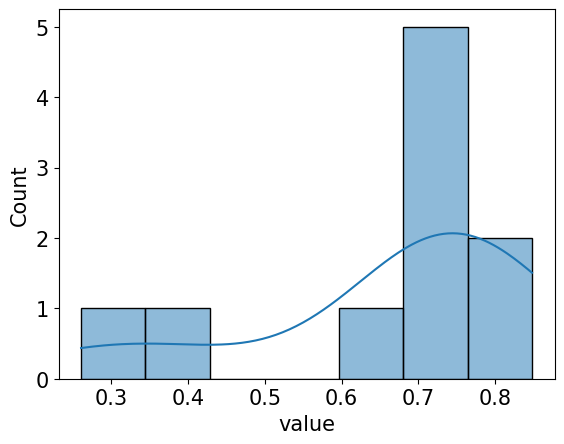

In [13]:
# @title Visualizing Bayesian Learning Results with Histograms

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load CSV file
df = pd.read_csv('reservoir.csv')

sns.histplot(df['value'], kde=True)
plt.show()


In [14]:
# @title Kernel density estimation (to avoid overfitting) and hyper-parameter determination


import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import numpy as np

# Importing CSV files
file_path = 'reservoir.csv'
df = pd.read_csv(file_path)

################


from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

# Extract data from 'value' to 'seed_value
data_columns = ['value', 'lag', 'dim', 'N_x', 'beta', 'density', 'input_scale', 'rho', 'alpha', 'seed_value']
data_optuna = df[data_columns]

# Data standardization (scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_optuna)

# Weight list (set weights for each parameter)
weights = np.array([3, 4, 4, 0.5,1.0, 1.0, 1.0, 1.0, 1.0, 0.1])

#As optuna continues, first of all, lag and dim will (roughly) converge, so we want to keep the weights of that pair large
#We would like a learning result that does not depend on seed_value
#Since we want to determine that ``value" is a stable index, so we want to take its weight rather large

# Apply Weights
weighted_data = scaled_data * weights

# Kernel density estimation
kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(weighted_data)

# Calculate the log density of each data point
log_density = kde.score_samples(weighted_data)

# Apply Threshold
threshold = 0.0
filtered_df = df[df['value'] >= threshold]
filtered_log_density = log_density[df['value'] >= threshold]

# Find the point of highest density
max_density_index = np.argmax(filtered_log_density)
max_density_point = filtered_df.iloc[max_density_index]

# Outputs the densest data points
print("The point with the highest density is:")
print(max_density_point)


# Decisive Reservoir hyperparameters
lag = int(max_density_point[1])
dim = int(max_density_point[2])
N_x = int(max_density_point[3])
beta = max_density_point[4]
density =max_density_point[5]
input_scale = max_density_point[6]
rho = max_density_point[7]
alpha = max_density_point[8]
seed_value =max_density_point[9]

print(f"Parameter Determination:")
print(f"lag: {lag}")
print(f"dim: {dim}")
print(f"N_x: {N_x}")
print(f"beta: {beta}")
print(f"density: {density}")
print(f"input_scale: {input_scale}")
print(f"rho: {rho}")
print(f"alpha: {alpha}")
print(f"seed_value: {seed_value}")


The point with the highest density is:
value            0.735421
lag              9.000000
dim             10.000000
N_x            130.000000
beta             0.504875
density          0.237520
input_scale      1.000000
rho              0.980000
alpha            0.373619
seed_value      27.757825
Name: 5, dtype: float64
Parameter Determination:
lag: 9
dim: 10
N_x: 130
beta: 0.5048753833041113
density: 0.2375196604959531
input_scale: 1.0
rho: 0.98
alpha: 0.3736190587341915
seed_value: 27.75782503278409


<ipython-input-14-24fcbd9141ed>:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lag = int(max_density_point[1])
<ipython-input-14-24fcbd9141ed>:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dim = int(max_density_point[2])
<ipython-input-14-24fcbd9141ed>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  N_x = int(max_density_point[3])
<ipython-input-14-24fcbd9141ed>:61: FutureWarning: Series.__getitem__ treating keys as positio

In [15]:
# @title Hyperparameters: model evaluation

test_num    = 100  # Estimated number of times for a single test (calculate one PCC)
                   # We want to consider the real data as a non-autonomous system, and not to predict too far into the future
discard_len = 10   # Number of steps at the beginning not learned
T_slide     = 88   # The test start time is shifted by making it like T_test+test_num
                   # We do not want to make predictions too far into the future
T_fix       = 0    # Initial time of prediction to be visualized: T_0+T_fix
                   # Can set the time between T_0 and T_0+T_test-1


Correlation coefficient with FILTER data: 0.8290174180377347
forecast period: 20


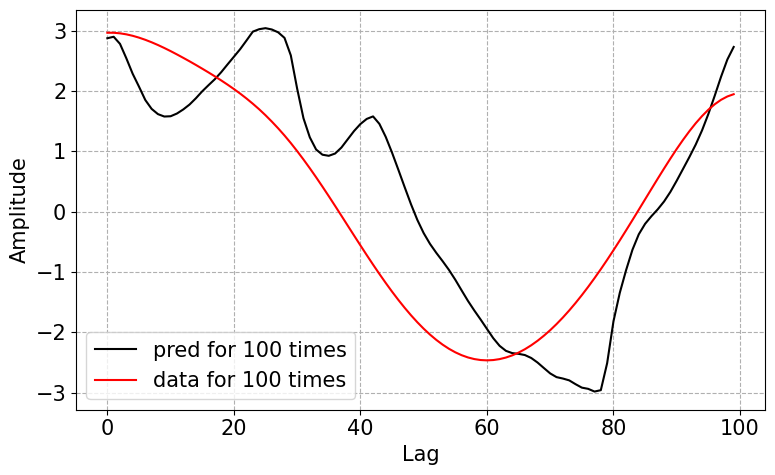

Correlation coefficient with FILTER data: 0.8290174180377347
forecast period: 20


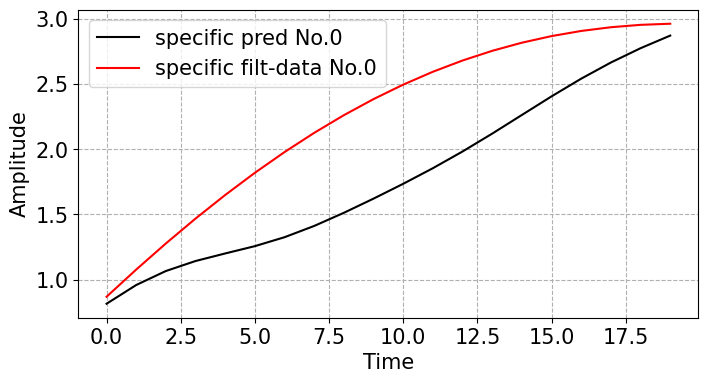

In [16]:
# @title Implementation of Model Evaluation

###############################
#The test start time

T_0 = T_train+lag*dim+T_slide
###############################

#Generate Win and W again

Win= input_matrix(N_x,seed_value,input_scale,dim)
W = recurrent_matrix(N_x, density, rho,seed_value)

data_delay_train = np.zeros((T_train+1,dim,test_num), dtype=float)
data_delay = np.zeros((T_train+T_test+1,dim,test_num), dtype=float)
test_Y = np.zeros((T_test,test_num))
test_D = np.zeros((T_test,test_num))
tentative_test_Y=np.zeros((T_test,dim,test_num))

#Convert test data to a delay coordinate system
for t in range(test_num):

    for i in range(dim):

          data_delay_train[:,i,t] = data_flt[T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series


# Initialization of training data

    train_U = np.zeros((T_train,dim), dtype=float)
    train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:T_train,:,t]
    train_D = data_delay_train[1:T_train+1,:,t]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))
    x_special = np.zeros(N_x)

    X_XT, D_XT,x_special = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len)

#Generate output weight matrix
    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###############


#Convert predictive data to a delay coordinate system

    for i in range(dim):

           data_delay[:,i,t] = data_flt[T_0+t-T_train-i*lag
                                        :T_0+t+T_test-i*lag+1] # i*lag step delayed time series



  #Predictive data generation

    tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_special,Win,W,Wout,alpha,T_test)
    test_Y[:,t] = tentative_test_Y[:,0,t]
    test_D[:,t] = data_delay[T_train+1
                             :T_train+T_test+1,0,t]


############################################
#Preparation for calculating autocorrelation

test_Y_cor = [0]*test_num
data_delay_cor = [0]*test_num



for t in range(test_num):

    test_Y_cor[t] = test_Y[T_test-1,t]
    data_delay_cor[t] = test_D[T_test-1,t]


# Calculate the autocorrelation coefficient

ac_flt = correlation(test_Y_cor[:],data_delay_cor[:])



######################
######################

print("Correlation coefficient with FILTER data:", ac_flt)
print("forecast period:", T_test)

fig = plt.figure(figsize=(8,5), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.plot(test_Y_cor[:], color="black", label=f"pred for {test_num} times")
plt.plot(data_delay_cor[:], color = "red",label=f"data for {test_num} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()

print("Correlation coefficient with FILTER data:",ac_flt)
print("forecast period:", T_test)



# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(test_Y[:,T_fix], color = "black",label=f"specific pred No.{T_fix}")
plt.plot(test_D[:,T_fix], color = "red",label=f"specific filt-data No.{T_fix}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

In [17]:
# @title Hyperparameters: PCC graphing

T_test_PCC  = 30    #Test period for making PCC graph, which should be longer than T_test
T_slide     = 88
test_num    = 100
discard_len = 10
T_fix       = 0


<Figure size 800x500 with 0 Axes>

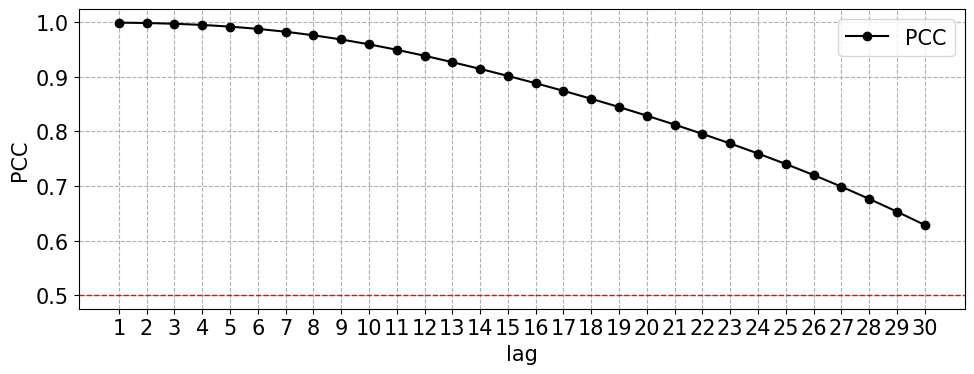

CPU times: user 2min 19s, sys: 1min 56s, total: 4min 16s
Wall time: 2min 36s


In [18]:
# @title Generate PCC graph
%%time



T_0=T_train+lag*dim+T_slide
###############################


#Generate Win and W again

Win= input_matrix(N_x,seed_value,input_scale,dim)
W = recurrent_matrix(N_x, density, rho,seed_value)

###############################


ac_flt = [0]*(T_test_PCC+1)


for t_test in range(1,T_test_PCC+1,1):

    data_delay_train = np.zeros((T_train+1,dim,test_num), dtype=float)
    data_delay = np.zeros((T_train+t_test+1,dim,test_num), dtype=float)
    test_Y = np.zeros((t_test,test_num))
    test_D = np.zeros((t_test,test_num))
    tentative_test_Y=np.zeros((t_test,dim,test_num))

#Convert test data to a delay coordinate system

    for t in range(test_num):

        for i in range(dim):

            data_delay_train[:,i,t] = data_flt[T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series



# Initialization of training data

        train_U = np.zeros((T_train,dim), dtype=float)
        train_D = np.zeros((T_train,dim), dtype=float)

#Input/output of training data

        train_U = data_delay_train[:T_train,:,t]
        train_D = data_delay_train[1:T_train+1,:,t]

##The last time data of the training data output must overlap with the test data!

#Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        X_XT, D_XT,x_special = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len)

 #Generate Wout
        Wout= None
        Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

###############


#Convert predictive data to a delay coordinate system


        for i in range(dim):

              data_delay[:,i,t] = data_flt[T_0+t-T_train-i*lag
                                        :T_0+t+t_test-i*lag+1] # i*lag step delayed time series


 #Predictive data generation


        tentative_test_Y[:,:,t] = run(data_delay[T_train:,:,t],x_special,Win,W,Wout,alpha,t_test)
        test_Y[:,t] = tentative_test_Y[:,0,t]
        test_D[:,t] = data_delay[T_train+1 \
                             :T_train+t_test+1,0,t]


#Preparation for calculating autocorrelation

    test_Y_cor = [0]*test_num
    data_delay_cor = [0]*test_num


    for t in range(test_num):

        test_Y_cor[t] = test_Y[t_test-1,t]
        data_delay_cor[t] = test_D[t_test-1,t]


# Calculate the autocorrelation coefficient

    ac_flt[t_test] = correlation(test_Y_cor[:],data_delay_cor[:])


##################
#Visualization
##################

fig = plt.figure(figsize=(8,5), dpi=100)
x = np.linspace(0, T_test_PCC,T_test_PCC+1)
fig = plt.figure(figsize=(10, 4), dpi=100)

plt.xticks(np.arange(1, T_test_PCC+1, 1))
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("lag")
plt.ylabel("PCC")

plt.plot(x[1::1],ac_flt[1::1], color="black", label=f"PCC", marker='o')

plt.legend()#loc='lower right')
# Add a dotted line to a specific horizontal scale (y=0.5)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()
